## Data Processing

In [1]:
# Import packages
import os
import sys
import warnings
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from scipy.interpolate import make_interp_spline

# PCA
from sklearn.decomposition import PCA

# Regression analysis
import statsmodels.api as sm

# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data', 'processed')
factor_dir = os.path.join(base_dir, 'data', 'processed', 'factors')
raw_data_dir = os.path.join(base_dir, 'data', 'raw')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
cov_df = pd.read_csv(os.path.join(data_dir, 'covariates_weekly.csv'))
cov_df.head()

,Phase,Year_Week,R1-RF,R2-RF,R3-RF,CMA,CRD,EG,HML,IA,LIQ,ME,MOM,Mkt-RF,RMW,ROE,SMB
0,Recovery,1991-14,0.808722,0.888317,1.046018,-0.570730,1.150221,-0.5419,-0.869560,-0.2831,1.472018,1.9119,0.891933,0.513137,-0.032457,0.4557,1.521326
1,Recovery,1991-15,0.264305,0.625699,0.993622,0.621385,2.298820,0.2974,0.269460,0.7554,1.155684,-0.6018,0.530151,1.069284,-0.160184,1.1641,-0.205230
2,Recovery,1991-16,0.397411,0.907257,1.589490,0.369853,-0.318141,0.1628,1.181054,0.0403,0.726344,-0.6797,-2.540450,0.823179,0.438583,-0.9019,-0.383025
3,Recovery,1991-17,-0.461241,-0.400725,-0.402482,-0.120218,-1.594360,0.7819,0.109392,-0.2596,-1.943223,-0.6371,-0.758405,-1.507046,0.410131,0.1809,-0.043628
4,Recovery,1991-18,0.821113,1.524843,2.275011,0.149088,-0.747710,-0.9039,0.358368,0.0811,-1.789523,-0.6211,0.498412,0.284198,0.149900,0.3691,-0.427979


## PCA for Recovery

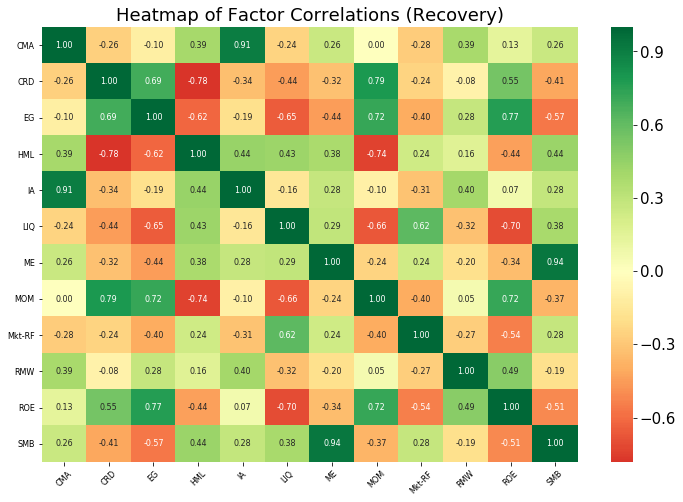

In [112]:
# check correlations for recovery
cur_phase = 'Recovery'
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
cur_phase_df = cov_df[cov_df['Phase'] == cur_phase]
factors_df = cur_phase_df.drop(
    columns = ['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF']
)
corr_matrix = factors_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Factor Correlations (Recovery)')
plt.show()

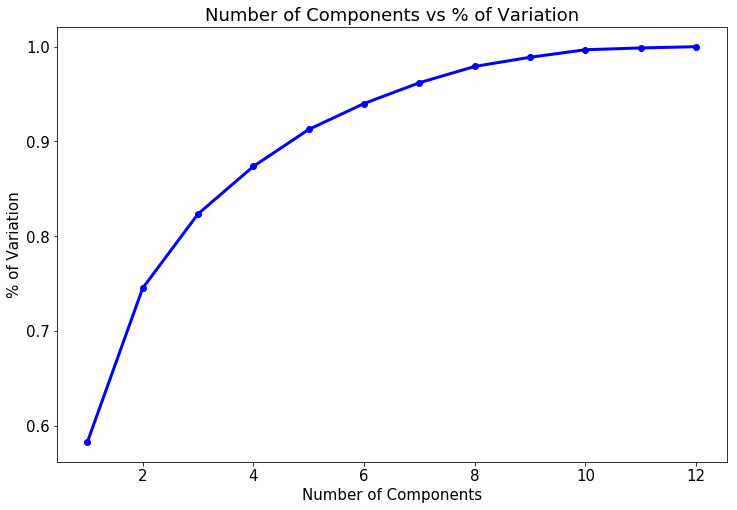

    Number of PCs  Total Variation %
0               1           0.582993
1               2           0.745368
2               3           0.823611
3               4           0.873757
4               5           0.912710
5               6           0.940052
6               7           0.961985
7               8           0.979167
8               9           0.988838
9              10           0.996777
10             11           0.998671
11             12           1.000000


In [113]:
var_sum = []
n_comps = [i + 1 for i in range(factors_df.shape[1])]
for i in n_comps:

    # PCA
    pca = PCA(n_components = i)
    pca.fit(factors_df)

    # Get the explained variance ratio
    var_sum.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
plt.plot(n_comps, var_sum, marker = 'o', color = "blue", linewidth = 3)
plt.xlabel("Number of Components")
plt.ylabel("% of Variation")
plt.title('Number of Components vs % of Variation')
plt.show()

print(pd.DataFrame({"Number of PCs": n_comps, "Total Variation %": var_sum}))

In [114]:
# Number of principal components to retain
# Note: originally 6 were chosen but we adjusted it back to 5 after regression results
n_components = 5 

# PCA
pca = PCA(n_components = n_components)
pca.fit(factors_df)

# Get the principal components
components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Transform original features into principal components
PC_df = pd.DataFrame(
    pca.transform(factors_df),
    columns = ['PC' + str(i + 1) for i in range(n_components)]
)

# Print results
print("Original features:")
print(factors_df)
print("\nPrincipal Components:")
print(components)
print("\nExplained Variance %:")
print(explained_variance_ratio)
print("\nTotal % of Variance Explained:")
print(np.sum(explained_variance_ratio))
print("\nTransformed features (after PCA):")
print(PC_df)

# Ignore future warning
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Original features:
          CMA       CRD      EG       HML      IA       LIQ      ME       MOM  \
0   -0.570730  1.150221 -0.5419 -0.869560 -0.2831  1.472018  1.9119  0.891933   
1    0.621385  2.298820  0.2974  0.269460  0.7554  1.155684 -0.6018  0.530151   
2    0.369853 -0.318141  0.1628  1.181054  0.0403  0.726344 -0.6797 -2.540450   
3   -0.120218 -1.594360  0.7819  0.109392 -0.2596 -1.943223 -0.6371 -0.758405   
4    0.149088 -0.747710 -0.9039  0.358368  0.0811 -1.789523 -0.6211  0.498412   
..        ...       ...     ...       ...     ...       ...     ...       ...   
170  0.468965 -2.252963 -2.8761  1.747091  0.6827  2.837267  1.2477 -2.208065   
171  0.336213  0.707019 -0.6243  0.977053  0.0416 -0.505852  0.5011 -0.341201   
172  0.658215  0.470343 -1.3840  1.810842 -0.2294  3.517048  1.5679 -2.254413   
173 -0.090647  0.097816  0.1746  0.507994  0.3084  0.323947  2.0320  0.391269   
174 -0.210127 -0.209019 -0.4445  0.238466 -0.3387 -0.506880 -0.7910 -0.490272   

       M

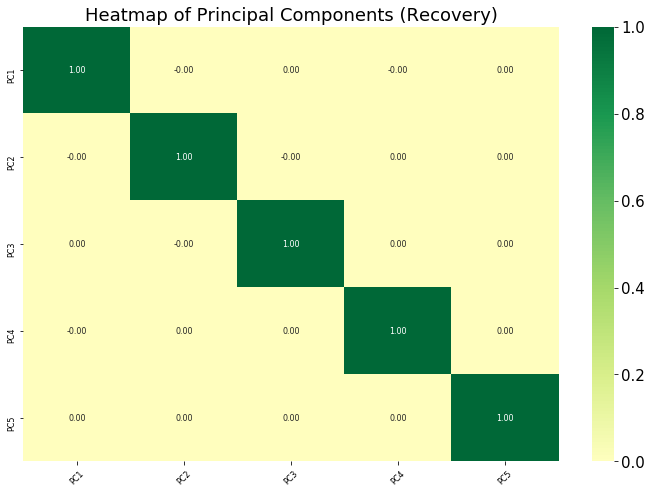

In [115]:
# heatmap of principal components
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
corr_matrix = PC_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Principal Components (Recovery)')
plt.show()

In [118]:
print("***** Regression on Low-Risk Portfolio (Recovery) *****")
print("\n")
x, y = PC_df, cur_phase_df['R1-RF'].values.reshape(-1, 1)
x = sm.add_constant(x)
r1_mdl = sm.OLS(y, x).fit()
print(r1_mdl.summary())
print("\n")

print("***** Regression on Medium-Risk Portfolio (Recovery) *****")
print("\n")
x, y = PC_df, cur_phase_df['R2-RF'].values.reshape(-1, 1)
x = sm.add_constant(x)
r2_mdl = sm.OLS(y, x).fit()
print(r2_mdl.summary())
print("\n")

print("***** Regression on High-Risk Portfolio (Recovery) *****")
print("\n")
x, y = PC_df, cur_phase_df['R3-RF'].values.reshape(-1, 1)
x = sm.add_constant(x)
r3_mdl = sm.OLS(y, x).fit()
print(r3_mdl.summary())

***** Regression on Low-Risk Portfolio (Recovery) *****


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     98.78
Date:                Thu, 07 Mar 2024   Prob (F-statistic):           2.70e-48
Time:                        16:45:22   Log-Likelihood:                -172.53
No. Observations:                 175   AIC:                             357.1
Df Residuals:                     169   BIC:                             376.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [57]:
# write csv
recovery_df = pd.concat([cur_phase_df, PC_df], axis = 1)
recovery_df.to_csv(os.path.join(data_dir, "recovery_factor_candidates.csv"), index = False)

## PCA for Expansion

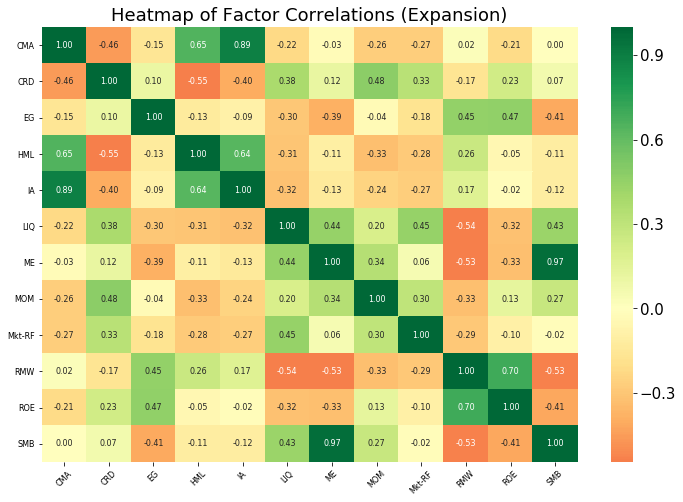

In [181]:
# check correlations for expansion
cur_phase = 'Expansion'
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
cur_phase_df = cov_df[cov_df['Phase'] == cur_phase].reset_index().drop(columns = ['index'])
factors_df = cur_phase_df.drop(
    columns = ['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF']
)
corr_matrix = factors_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Factor Correlations (Expansion)')
plt.show()

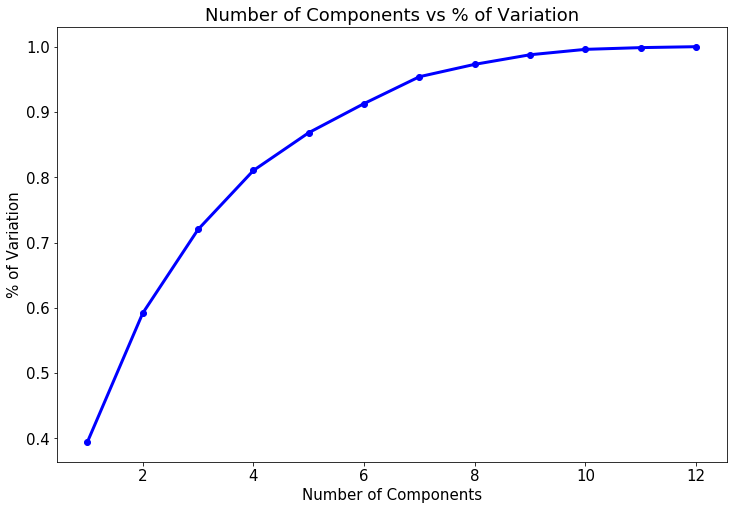

    Number of PCs  Total Variation %
0               1           0.394307
1               2           0.591707
2               3           0.719967
3               4           0.810344
4               5           0.868223
5               6           0.912851
6               7           0.954002
7               8           0.972965
8               9           0.987640
9              10           0.995908
10             11           0.998569
11             12           1.000000


In [182]:
var_sum = []
n_comps = [i + 1 for i in range(factors_df.shape[1])]
for i in n_comps:

    # PCA
    pca = PCA(n_components = i)
    pca.fit(factors_df)

    # Get the explained variance ratio
    var_sum.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
plt.plot(n_comps, var_sum, marker = 'o', color = "blue", linewidth = 3)
plt.xlabel("Number of Components")
plt.ylabel("% of Variation")
plt.title('Number of Components vs % of Variation')
plt.show()

print(pd.DataFrame({"Number of PCs": n_comps, "Total Variation %": var_sum}))

In [183]:
# Number of principal components to retain
n_components = 7

# PCA
pca = PCA(n_components = n_components)
pca.fit(factors_df)

# Get the principal components
components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Transform original features into principal components
PC_df = pd.DataFrame(
    pca.transform(factors_df),
    columns = ['PC' + str(i + 1) for i in range(n_components)]
)

# Print results
print("Original features:")
print(factors_df)
print("\nPrincipal Components:")
print(components)
print("\nExplained Variance %:")
print(explained_variance_ratio)
print("\nTotal % of Variance Explained:")
print(np.sum(explained_variance_ratio))
print("\nTransformed features (after PCA):")
print(PC_df)

# Ignore future warning
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Original features:
          CMA       CRD      EG       HML      IA       LIQ      ME       MOM  \
0   -0.230001  1.763909 -0.6789 -0.020666  0.1684  1.618215  0.6076  1.205148   
1    0.416802  0.115686  0.2564  0.112702  0.4531 -2.548211  0.0699 -0.411002   
2   -0.351042  3.741018  0.3515 -1.336396 -0.2910 -0.612267 -0.4808  0.754943   
3   -0.260263  0.319923  0.5365 -0.510014 -0.3932 -0.605937 -0.5100  0.409969   
4   -0.988220  5.208499 -0.3102 -2.524331 -0.4444 -0.591957 -0.1499  3.168165   
..        ...       ...     ...       ...     ...       ...     ...       ...   
594 -0.996834 -1.946299 -1.2476  1.297009 -0.3101  1.011403 -0.0791 -0.025489   
595  3.044254 -4.204014 -1.4514  6.289589  3.4328  0.729911  0.9374 -0.103613   
596  1.143076 -2.406852 -0.0608  2.503652  1.1785 -1.184384 -0.7582 -3.260037   
597 -0.741420  0.729582 -0.1685 -1.038596 -0.4385 -0.426537 -0.0506 -0.253249   
598 -0.450903  0.508082  0.1300 -0.723883  0.2048  3.654092  1.4365  4.337348   

       M

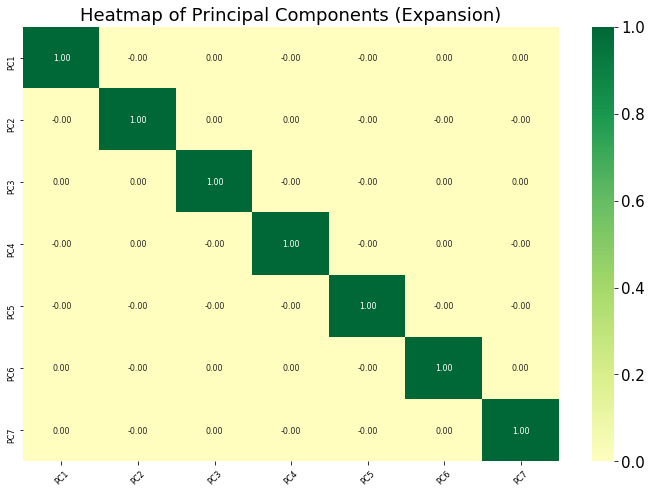

In [184]:
# heatmap of principal components
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
corr_matrix = PC_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Principal Components (Expansion)')
plt.show()

In [185]:
print("***** Regression on Low-Risk Portfolio (Expansion) *****")
print("\n")
x, y = PC_df, cur_phase_df['R1-RF']
x = sm.add_constant(x)
r1_mdl = sm.OLS(y, x).fit()
print(r1_mdl.summary())
print("\n")

print("***** Regression on Medium-Risk Portfolio (Expansion) *****")
print("\n")
x, y = PC_df, cur_phase_df['R2-RF']
x = sm.add_constant(x)
r2_mdl = sm.OLS(y, x).fit()
print(r2_mdl.summary())
print("\n")

print("***** Regression on High-Risk Portfolio (Expansion) *****")
print("\n")
x, y = PC_df, cur_phase_df['R3-RF']
x = sm.add_constant(x)
r3_mdl = sm.OLS(y, x).fit()
print(r3_mdl.summary())

***** Regression on Low-Risk Portfolio (Expansion) *****


                            OLS Regression Results                            
Dep. Variable:                  R1-RF   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     163.0
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          1.76e-133
Time:                        16:59:34   Log-Likelihood:                -823.36
No. Observations:                 599   AIC:                             1663.
Df Residuals:                     591   BIC:                             1698.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [186]:
# write csv
expansion_df = pd.concat([cur_phase_df, PC_df.reset_index().drop(columns = ['index'])], axis = 1)
expansion_df.to_csv(os.path.join(data_dir, "expansion_factor_candidates.csv"), index = False)

## PCA for Downturn

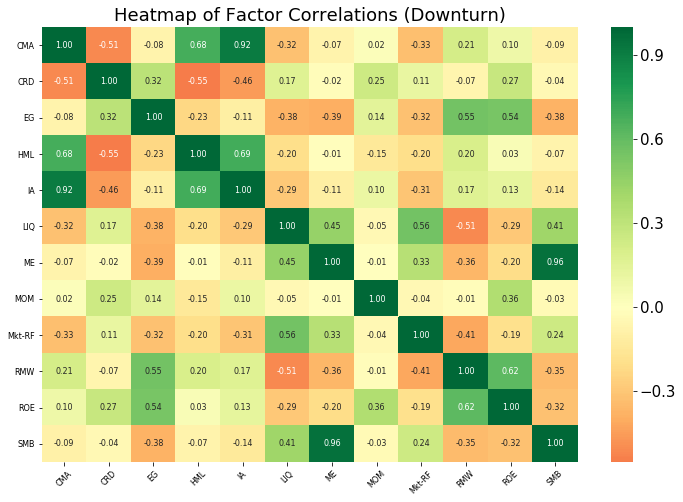

In [188]:
# check correlations for expansion
cur_phase = 'Downturn'
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
cur_phase_df = cov_df[cov_df['Phase'] == cur_phase].reset_index().drop(columns = ['index'])
factors_df = cur_phase_df.drop(
    columns = ['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF']
)
corr_matrix = factors_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Factor Correlations (Downturn)')
plt.show()

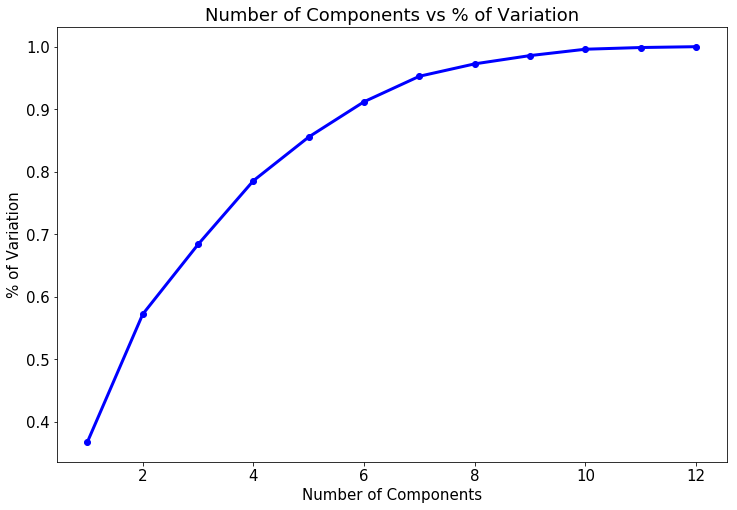

    Number of PCs  Total Variation %
0               1           0.367986
1               2           0.572285
2               3           0.683877
3               4           0.785743
4               5           0.855649
5               6           0.912010
6               7           0.952751
7               8           0.972559
8               9           0.985780
9              10           0.995944
10             11           0.998662
11             12           1.000000


In [189]:
var_sum = []
n_comps = [i + 1 for i in range(factors_df.shape[1])]
for i in n_comps:

    # PCA
    pca = PCA(n_components = i)
    pca.fit(factors_df)

    # Get the explained variance ratio
    var_sum.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
plt.plot(n_comps, var_sum, marker = 'o', color = "blue", linewidth = 3)
plt.xlabel("Number of Components")
plt.ylabel("% of Variation")
plt.title('Number of Components vs % of Variation')
plt.show()

print(pd.DataFrame({"Number of PCs": n_comps, "Total Variation %": var_sum}))

In [190]:
# Number of principal components to retain
# Note: originally 7 were chosen but we adjusted it back to 6 after regression results
n_components = 6

# PCA
pca = PCA(n_components = n_components)
pca.fit(factors_df)

# Get the principal components
components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Transform original features into principal components
PC_df = pd.DataFrame(
    pca.transform(factors_df),
    columns = ['PC' + str(i + 1) for i in range(n_components)]
)

# Print results
print("Original features:")
print(factors_df)
print("\nPrincipal Components:")
print(components)
print("\nExplained Variance %:")
print(explained_variance_ratio)
print("\nTotal % of Variance Explained:")
print(np.sum(explained_variance_ratio))
print("\nTransformed features (after PCA):")
print(PC_df)

# Ignore future warning
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Original features:
          CMA       CRD      EG       HML      IA       LIQ      ME       MOM  \
0    0.540161  0.213850  0.5191  0.058928  0.5993 -0.642041 -0.4267  0.129723   
1   -0.480612  0.754048  0.4809 -0.959538 -0.2545  0.058256 -0.8293  0.490448   
2   -0.250374  0.417990  1.2431 -0.110430  0.0117  1.610168  0.3045  1.094305   
3   -0.300879  3.726759  0.0612 -0.678772  0.0841  1.466755 -1.0562  0.048096   
4   -0.749001  0.317212 -0.2788 -0.180789 -0.8631  0.520398  1.5680 -0.917106   
..        ...       ...     ...       ...     ...       ...     ...       ...   
664 -0.237935  0.304211  0.8184 -0.326703 -0.7675  0.339960  0.9775 -0.390437   
665  1.274131  0.558647  0.0329  0.857796  1.4348 -0.753475  0.8305  3.053458   
666 -4.074298  4.081485  0.6570 -3.498302 -4.1132 -4.332406 -1.6599 -2.570717   
667 -3.749078  2.702257  0.0532 -5.363049 -5.4385 -1.811260 -1.3220 -5.076173   
668  1.470452 -0.579190 -0.6715  2.230789  1.9482 -4.391077  0.9774  5.167854   

       M

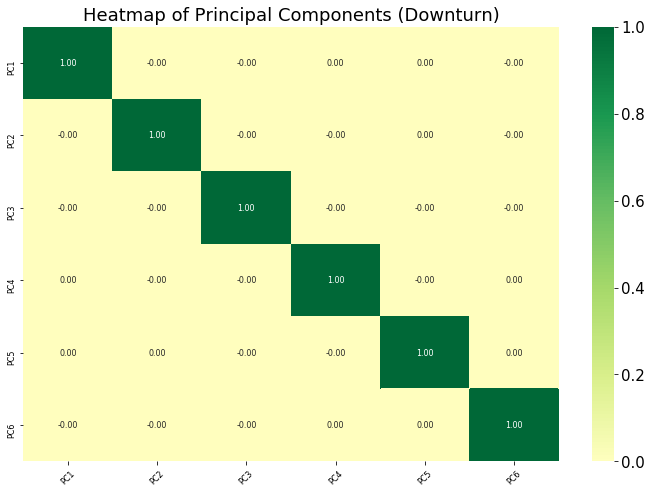

In [191]:
# heatmap of principal components
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
corr_matrix = PC_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Principal Components (Downturn)')
plt.show()

In [192]:
print("***** Regression on Low-Risk Portfolio (Downturn) *****")
print("\n")
x, y = PC_df, cur_phase_df['R1-RF']
x = sm.add_constant(x)
r1_mdl = sm.OLS(y, x).fit()
print(r1_mdl.summary())
print("\n")

print("***** Regression on Medium-Risk Portfolio (Downturn) *****")
print("\n")
x, y = PC_df, cur_phase_df['R2-RF']
x = sm.add_constant(x)
r2_mdl = sm.OLS(y, x).fit()
print(r2_mdl.summary())
print("\n")

print("***** Regression on High-Risk Portfolio (Downturn) *****")
print("\n")
x, y = PC_df, cur_phase_df['R3-RF']
x = sm.add_constant(x)
r3_mdl = sm.OLS(y, x).fit()
print(r3_mdl.summary())

***** Regression on Low-Risk Portfolio (Downturn) *****


                            OLS Regression Results                            
Dep. Variable:                  R1-RF   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     155.0
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          1.36e-122
Time:                        16:59:35   Log-Likelihood:                -993.39
No. Observations:                 669   AIC:                             2001.
Df Residuals:                     662   BIC:                             2032.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [193]:
# write csv
downturn_df = pd.concat([cur_phase_df, PC_df.reset_index().drop(columns = ['index'])], axis = 1)
downturn_df.to_csv(os.path.join(data_dir, "downturn_factor_candidates.csv"), index = False)

## PCA for Depression

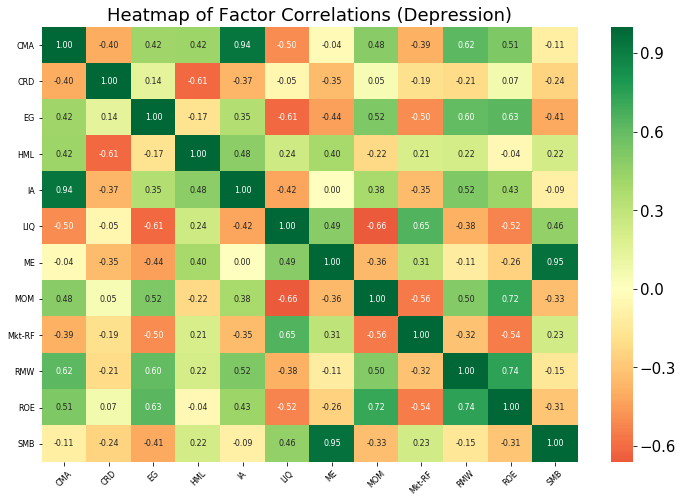

In [198]:
# check correlations for expansion
cur_phase = 'Depression'
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
cur_phase_df = cov_df[cov_df['Phase'] == cur_phase].reset_index().drop(columns = ['index'])
factors_df = cur_phase_df.drop(
    columns = ['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF']
)
corr_matrix = factors_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Factor Correlations (Depression)')
plt.show()

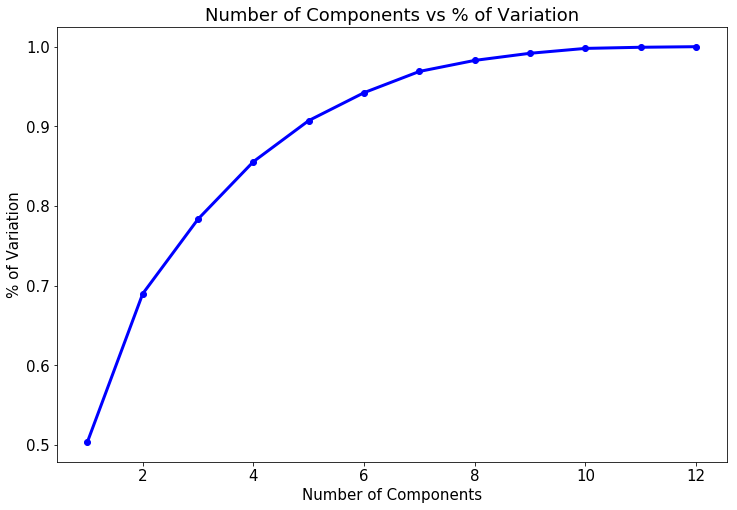

    Number of PCs  Total Variation %
0               1           0.503848
1               2           0.689959
2               3           0.783648
3               4           0.855721
4               5           0.907265
5               6           0.942291
6               7           0.968952
7               8           0.982793
8               9           0.991736
9              10           0.997849
10             11           0.999274
11             12           1.000000


In [199]:
var_sum = []
n_comps = [i + 1 for i in range(factors_df.shape[1])]
for i in n_comps:

    # PCA
    pca = PCA(n_components = i)
    pca.fit(factors_df)

    # Get the explained variance ratio
    var_sum.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
plt.plot(n_comps, var_sum, marker = 'o', color = "blue", linewidth = 3)
plt.xlabel("Number of Components")
plt.ylabel("% of Variation")
plt.title('Number of Components vs % of Variation')
plt.show()

print(pd.DataFrame({"Number of PCs": n_comps, "Total Variation %": var_sum}))

In [206]:
# Number of principal components to retain
n_components = 6

# PCA
pca = PCA(n_components = n_components)
pca.fit(factors_df)

# Get the principal components
components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Transform original features into principal components
PC_df = pd.DataFrame(
    pca.transform(factors_df),
    columns = ['PC' + str(i + 1) for i in range(n_components)]
)

# Print results
print("Original features:")
print(factors_df)
print("\nPrincipal Components:")
print(components)
print("\nExplained Variance %:")
print(explained_variance_ratio)
print("\nTotal % of Variance Explained:")
print(np.sum(explained_variance_ratio))
print("\nTransformed features (after PCA):")
print(PC_df)

# Ignore future warning
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Original features:
          CMA       CRD      EG       HML      IA       LIQ      ME       MOM  \
0    0.425321  2.061051  0.6081  1.574002  0.7610 -0.126468 -1.2234  1.710463   
1   -1.382940  6.211808  0.7539 -1.992796 -0.4935  3.069058 -2.2778  2.410622   
2    0.315992 -0.830714  0.8146 -0.270379 -0.0047 -0.141985  0.8671  1.186043   
3    0.600223  1.482078  0.2906  0.468987  0.6343  0.106528 -2.2285  0.280654   
4   -1.464212  1.682516 -0.6426 -0.332116 -0.9143  0.254159 -0.3451 -1.127028   
..        ...       ...     ...       ...     ...       ...     ...       ...   
283 -0.485292 -1.407705 -1.4244 -0.143893 -0.2634  1.732601  0.2691 -0.973392   
284  1.735561 -1.614857  0.5352  0.917433  1.4937 -1.772066 -2.3515 -0.320548   
285 -0.173153  1.298617 -0.7802  0.240468 -0.3454  0.917606  1.2397  1.088540   
286  0.429173  1.073625 -0.5350 -1.267848  0.8561 -0.700302  0.3524  1.692891   
287  0.868513 -0.184212  0.2084  0.005867  1.0891  0.108703 -1.1410  0.430664   

       M

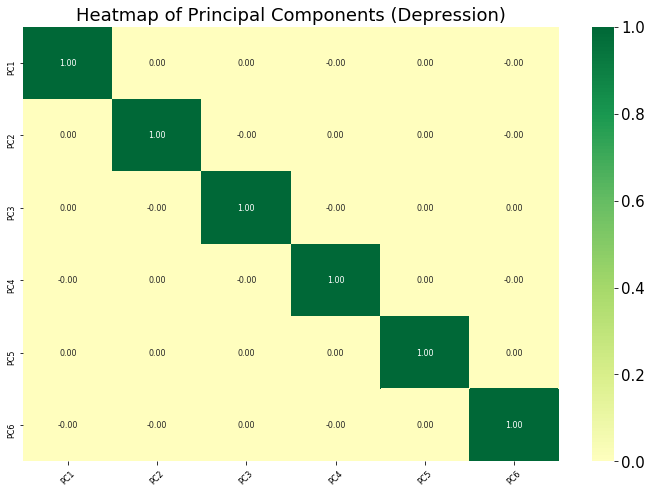

In [207]:
# heatmap of principal components
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
corr_matrix = PC_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Principal Components (Depression)')
plt.show()

In [208]:
print("***** Regression on Low-Risk Portfolio (Depression) *****")
print("\n")
x, y = PC_df, cur_phase_df['R1-RF']
x = sm.add_constant(x)
r1_mdl = sm.OLS(y, x).fit()
print(r1_mdl.summary())
print("\n")

print("***** Regression on Medium-Risk Portfolio (Depression) *****")
print("\n")
x, y = PC_df, cur_phase_df['R2-RF']
x = sm.add_constant(x)
r2_mdl = sm.OLS(y, x).fit()
print(r2_mdl.summary())
print("\n")

print("***** Regression on High-Risk Portfolio (Depression) *****")
print("\n")
x, y = PC_df, cur_phase_df['R3-RF']
x = sm.add_constant(x)
r3_mdl = sm.OLS(y, x).fit()
print(r3_mdl.summary())

***** Regression on Low-Risk Portfolio (Depression) *****


                            OLS Regression Results                            
Dep. Variable:                  R1-RF   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.457
Date:                Thu, 07 Mar 2024   Prob (F-statistic):              0.193
Time:                        17:08:49   Log-Likelihood:                -1427.9
No. Observations:                 288   AIC:                             2870.
Df Residuals:                     281   BIC:                             2895.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [209]:
# write csv
depression_df = pd.concat([cur_phase_df, PC_df.reset_index().drop(columns = ['index'])], axis = 1)
depression_df.to_csv(os.path.join(data_dir, "depression_factor_candidates.csv"), index = False)